# Importy

In [ ]:
import pandas as pd
import os
import re
from google.colab import drive
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
#model
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
#metryki
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
#sieć
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
#!pip install --upgrade tensorflow

# Ładowanie i przygotowanie danych, wstępna analiza

In [ ]:
# ładowanie danych z dysku i łączenie ich w zbiory x i y
warnings.filterwarnings("ignore")

drive.mount('/content/drive')
dir = '/content/drive/MyDrive/grammatical+facial+expressions/grammatical_facial_expression'

x = pd.DataFrame()
y = pd.DataFrame()

# z tym patternem chodzi o pozbycie sie tego objaśnienia (0x, 0y, 0z...) i wrzucenie go na kolumny
valid_data_pattern = re.compile(r'^[0-9\.\-\s]+$')
columns = []
add_columns_names = True
num_columns = 301

for filename in sorted(os.listdir(dir)):
    file_path = os.path.join(dir, filename)

    if filename.endswith("_datapoints.txt"):
      data = []
      current_record = []
      # i robię to tu
      with open(file_path, 'r') as file:
          for line in file:
            if re.match(valid_data_pattern, line):
              line_values = line.strip().split()
              line_values = [float(value) for value in line_values if value]

              current_record.extend(line_values)

              if len(current_record) >= num_columns:
                    data.append(current_record[:num_columns])
                    current_record = current_record[num_columns:]
            elif add_columns_names:
              line_values = line.strip().split()
              columns += line_values
      add_columns_names = False

      df = pd.DataFrame(data)
      x = pd.concat([x, df], axis=0, ignore_index=True)

    elif filename.endswith("_targets.txt"):
        df = pd.read_csv(file_path, sep=" ",  header=None)
        file_name = os.path.basename(filename)
        expression = filename.split('_')[1]
        # sa takie 2 gesty z nazwa dwuczłonową
        if expression == "wh" or expression == "yn":
            expression += "_" + filename.split('_')[2]

        df.iloc[:, 0] = df.iloc[:, 0].astype(int).replace({1: expression, 0: 'unknown expression'})
        y = pd.concat([y, df], axis=0, ignore_index=True)
# doczytałam i pierwsza kolumna to czas
columns[0] = 'time'
x.columns = columns
print(x)
print(y)
print(y.iloc[:,0].unique())

Mounted at /content/drive
               time       0x       0y      0z       1x       1y      1z  \
0      1.390385e+09  244.672  208.182   895.0  240.949  205.708   890.0   
1      1.390385e+09  265.953  195.731  1016.0  262.556  193.301  1007.0   
2      1.390385e+09  272.755  192.786  1060.0  269.481  190.460  1056.0   
3      1.390385e+09  281.890  190.533  1129.0  278.861  188.023  1129.0   
4      1.390385e+09  283.933  193.201  1159.0  280.955  190.877  1159.0   
...             ...      ...      ...     ...      ...      ...     ...   
27931  1.391186e+09  327.201  227.957  1265.0  324.667  225.769  1270.0   
27932  1.391186e+09  327.201  227.957  1265.0  324.667  225.769  1275.0   
27933  1.391186e+09  327.198  227.959  1265.0  324.664  225.769  1275.0   
27934  1.391186e+09  327.198  227.959  1265.0  324.664  225.769  1275.0   
27935  1.391186e+09  327.178  227.973  1265.0  324.643  225.784  1270.0   

            2x       2y      2z  ...     96z      97x      97y     97z  \

In [ ]:
# kodowanie etykiet
label_mapping = {'unknown expression': 0, 'affirmative' : 1, 'conditional' : 2, 'doubt' : 3, 'emphasis' : 4,
 'negative' : 5, 'relative' : 6, 'topics' : 7, 'wh_question' : 8, 'yn_question' : 9}

y_encoded = y.replace(label_mapping)
print(y_encoded)

print(y_encoded.iloc[:,0].unique())
# podział na zbiór treningowy i testowy
x_train, x_test, y_train, y_test = train_test_split(x, y_encoded, test_size=0.2, random_state=42)

       0
0      0
1      0
2      0
3      0
4      0
...   ..
27931  0
27932  0
27933  0
27934  0
27935  0

[27936 rows x 1 columns]
[0 1 2 3 4 5 6 7 8 9]


Liczba rekordów w zbiorze treningowym: 22348
Liczba cech w zbiorze treningowym: 301
Liczba rekordów w zbiorze testowym: 5588
Liczba cech w zbiorze testowym: 301
Rozkład kategorii(%):
0
0    64.703777
3     4.564167
9     4.443351
5     4.389655
6     4.295686
2     4.098801
8     4.085377
1     3.378378
4     3.109898
7     2.930911
Name: proportion, dtype: float64
Rozkład kategorii(%):
0
0    64.405870
5     4.634932
9     4.545455
3     4.491768
8     4.384395
6     4.187545
2     3.954903
1     3.346457
7     3.078024
4     2.970651
Name: proportion, dtype: float64


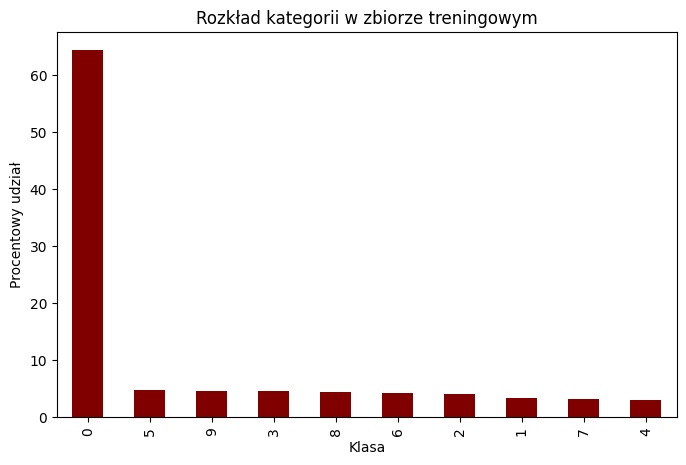

False


In [ ]:
# wstępna analiza
y.iloc[:, 0].unique()

# liczba rekordów i cech w zbiorze treningowym i testowym
train_records = x_train.shape[0]
test_records = x_test.shape[0]

train_features = x_train.shape[1]
test_features = x_test.shape[1]

print(f"Liczba rekordów w zbiorze treningowym: {train_records}")
print(f"Liczba cech w zbiorze treningowym: {train_features}")
print(f"Liczba rekordów w zbiorze testowym: {test_records}")
print(f"Liczba cech w zbiorze testowym: {test_features}")

# rozkład kategorii(%)
class_distribution = y_train[0].value_counts(normalize=True) * 100
print("Rozkład kategorii(%):")
print(class_distribution)

# rozkład kategorii(%)
class_distribution = y_test[0].value_counts(normalize=True) * 100
print("Rozkład kategorii(%):")
print(class_distribution)

# wykres słupkowy dla rozkładu kategorii
plt.figure(figsize=(8, 5))
class_distribution.plot(kind='bar', color='maroon')
plt.title("Rozkład kategorii w zbiorze treningowym")
plt.xlabel("Klasa")
plt.ylabel("Procentowy udział")
plt.show()

#czy są jakieś wartości brakujące
print(x.isnull().values.any())

In [ ]:
# normalizacja danych(pod siec)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Tworzenie modelu RandomForest z optymalizacją parametrów

In [ ]:
rf = RandomForestClassifier(class_weight='balanced',random_state=42, n_estimators = 150, max_depth = 30)
rf.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=30, n_estimators=150,
                       random_state=42)

In [ ]:
y_pred = rf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9352183249821046


In [ ]:
# Przechowywanie wyników
results = []

# Testowanie różnych hiperparametrów
for n_estimators in [50, 100, 150, 200]:
    for max_depth in [10, 20, 30, 40]:
        rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', random_state=42)
        rf_clf.fit(x_train, y_train)
        y_pred = rf_clf.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)

        # Zapisanie wyników
        results.append({'n_estimators': n_estimators, 'max_depth': max_depth, 'accuracy': accuracy})
        print(f"n_estimators={n_estimators}, max_depth={max_depth}, accuracy={accuracy}")

# Znalezienie najlepszych hiperparametrów
best_params = max(results, key=lambda x: x['accuracy'])
print("\nNajlepsze hiperparametry:")
print(f"n_estimators: {best_params['n_estimators']}, max_depth: {best_params['max_depth']}, accuracy: {best_params['accuracy']}")


n_estimators=50, max_depth=10, accuracy=0.6680386542591267
n_estimators=50, max_depth=20, accuracy=0.9171438797423049
n_estimators=50, max_depth=30, accuracy=0.9311023622047244
n_estimators=50, max_depth=40, accuracy=0.9327129563350036
n_estimators=100, max_depth=10, accuracy=0.6633858267716536
n_estimators=100, max_depth=20, accuracy=0.9187544738725841
n_estimators=100, max_depth=30, accuracy=0.9337866857551896
n_estimators=100, max_depth=40, accuracy=0.9332498210450967
n_estimators=150, max_depth=10, accuracy=0.6571224051539012
n_estimators=150, max_depth=20, accuracy=0.9212598425196851
n_estimators=150, max_depth=30, accuracy=0.9352183249821046
n_estimators=150, max_depth=40, accuracy=0.9321760916249106
n_estimators=200, max_depth=10, accuracy=0.6619541875447388
n_estimators=200, max_depth=20, accuracy=0.920722977809592
n_estimators=200, max_depth=30, accuracy=0.9345025053686471
n_estimators=200, max_depth=40, accuracy=0.9312813171080888

Najlepsze hiperparametry:
n_estimators: 150,

In [ ]:
results_df = pd.DataFrame(results)

# Analiza skuteczności RandomForest

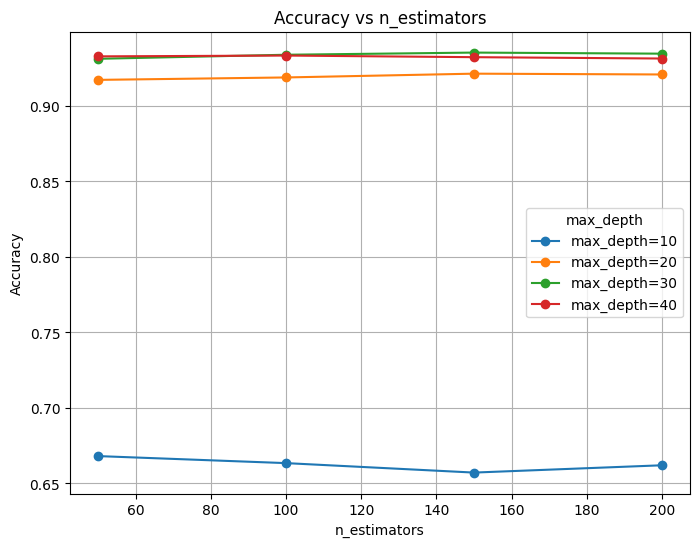

In [ ]:
'''
Pierwszy wykres (Accuracy vs n_estimators):

Pokazuje, jak zmienia się dokładność przy różnych liczbach drzew (n_estimators).
Linie oznaczają różne wartości max_depth.

'''
plt.figure(figsize=(8, 6))
for depth in results_df['max_depth'].unique():
    subset = results_df[results_df['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['accuracy'], marker='o', label=f"max_depth={depth}")

plt.title("Accuracy vs n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend(title="max_depth")
plt.grid()
plt.show()


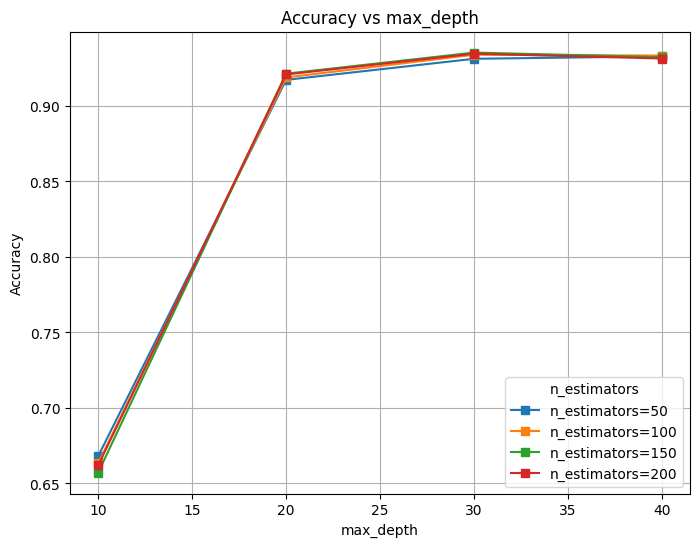

In [ ]:
'''
Drugi wykres (Accuracy vs max_depth):

Pokazuje, jak zmienia się dokładność przy różnych głębokościach drzew (max_depth).
Linie oznaczają różne wartości n_estimators
'''
plt.figure(figsize=(8, 6))
for n_est in results_df['n_estimators'].unique():
    subset = results_df[results_df['n_estimators'] == n_est]
    plt.plot(subset['max_depth'], subset['accuracy'], marker='s', label=f"n_estimators={n_est}")

plt.title("Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend(title="n_estimators")
plt.grid()
plt.show()

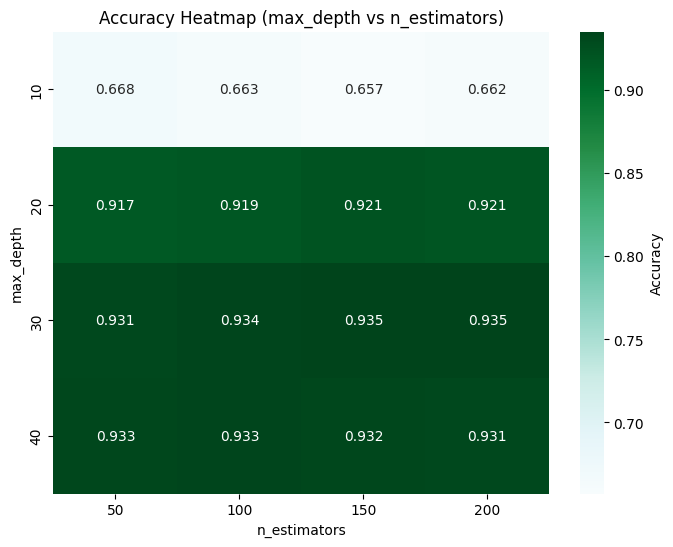

In [ ]:
# Przekształcenie danych do formatu pivot (max_depth jako wiersze, n_estimators jako kolumny)
heatmap_data = results_df.pivot(index='max_depth', columns='n_estimators', values='accuracy')

# Tworzenie heatmapy
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="Greens", cbar_kws={'label': 'Accuracy'})
plt.title("Accuracy Heatmap (max_depth vs n_estimators)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

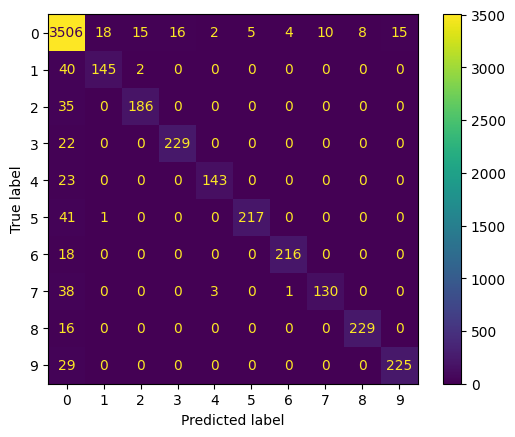

In [ ]:
#Stworzenie macierzy pomyłek
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
y_binary = y_test.iloc[:, 0].apply(lambda x: 1 if x == 'unknown expression' else 0)

14368    1
9419     0
1972     1
24310    0
20249    0
        ..
9161     1
26551    0
14339    0
24787    0
9250     1
Name: 0, Length: 5588, dtype: int64


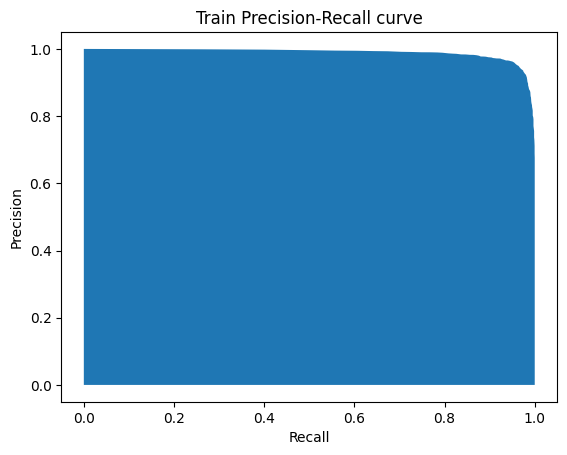

In [ ]:
precision, recall, thresholds = precision_recall_curve(y_binary, y_prob_7)
plt.fill_between(recall, precision)
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.title("Train Precision-Recall curve");

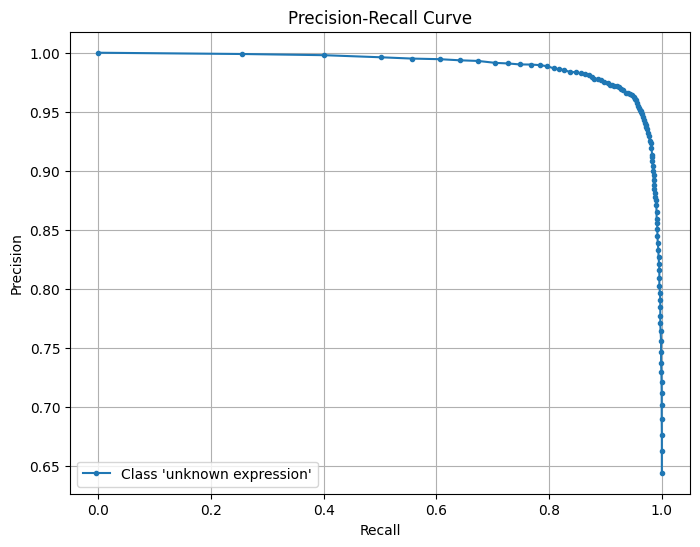

In [ ]:
#na danych nie zakodowanych
# 4 => negative

class_of_interest = 7
target_class = 'unknown expression'

y_binary = y_test.iloc[:, 0].apply(lambda x: 1 if x == target_class else 0)

# Krok 2: Wybór prawdopodobieństw przypisania do klasy '7'
y_prob_class = prob[:, class_of_interest]  # Kolumna odpowiadająca klasie 7

# Krok 3: Obliczenie Precision, Recall i progów
precision, recall, thresholds = precision_recall_curve(y_binary, y_prob_class)

# Krok 4: Wizualizacja Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f"Class '{target_class}'")
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_predictions = rf.predict(x_test)
print("\nRandom Forest:")
print("Accuracy:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))
print(confusion_matrix(y_test, rf_predictions))


Random Forest:
Accuracy: 0.9332498210450967
                    precision    recall  f1-score   support

       affirmative       0.92      0.74      0.82       187
       conditional       0.94      0.82      0.88       221
             doubt       0.93      0.91      0.92       251
          emphasis       0.95      0.85      0.90       166
          negative       0.98      0.83      0.90       259
          relative       0.97      0.93      0.95       234
            topics       0.92      0.77      0.84       172
unknown expression       0.93      0.97      0.95      3599
       wh_question       0.95      0.94      0.94       245
       yn_question       0.93      0.89      0.91       254

          accuracy                           0.93      5588
         macro avg       0.94      0.87      0.90      5588
      weighted avg       0.93      0.93      0.93      5588

[[ 139    1    0    0    0    0    0   47    0    0]
 [   0  182    0    0    0    0    0   39    0    0]
 [   0

# Model sieci neuronowej

In [ ]:
print(x_train.dtypes)
print(y_train.dtypes)

time    float64
0x      float64
0y      float64
0z      float64
1x      float64
         ...   
98y     float64
98z     float64
99x     float64
99y     float64
99z     float64
Length: 301, dtype: object
0    int64
dtype: object


In [ ]:
num_of_classes = y.nunique()[0]

In [ ]:
model_variation1 = Sequential()
model_variation1.add(Dense(train_features*3, activation="relu", input_shape=(x_train.shape[1],)))
model_variation1.add(Dense(train_features*2, activation="relu"))
model_variation1.add(Dense(num_of_classes, activation="softmax"))
model_variation1.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation1.fit(x_train_scaled, y_train, epochs=10 , batch_size=32, verbose=1)

loss_var1_10, accuracy_var1_10 = model_variation1.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 1 - Accuracy:", accuracy_var1_10)

# w raporcoe wykres

Epoch 1/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6574 - loss: 1.2575
Epoch 2/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7081 - loss: 0.9162
Epoch 3/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7362 - loss: 0.8001
Epoch 4/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7481 - loss: 0.7439
Epoch 5/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7700 - loss: 0.6835
Epoch 6/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7835 - loss: 0.6381
Epoch 7/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7887 - loss: 0.6101
Epoch 8/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7926 - loss: 0.5961
Epoch 9/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.7974 - loss: 0.5757
Epoch 10/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.8071 - loss: 0.5533
Model Variation 1 - Accuracy: 0.8074445128440857


In [ ]:
accuracy_var1_10 = 0.8074445128440857

In [ ]:
model_variation1 = Sequential()
model_variation1.add(Dense(train_features*3, activation="relu", input_shape=(x_train.shape[1],)))
model_variation1.add(Dense(train_features*2, activation="relu"))
model_variation1.add(Dense(num_of_classes, activation="softmax"))
model_variation1.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation1.fit(x_train_scaled, y_train, epochs=50 , batch_size=32, verbose=1)

loss_var1_50, accuracy_var1_50 = model_variation1.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 1 - Accuracy:", accuracy_var1_50)

Epoch 1/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6593 - loss: 1.2674
Epoch 2/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7026 - loss: 0.9384
Epoch 3/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7338 - loss: 0.8166
Epoch 4/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7471 - loss: 0.7647
Epoch 5/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.7620 - loss: 0.6982
Epoch 6/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7787 - loss: 0.6486
Epoch 7/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7880 - loss: 0.6187
Epoch 8/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.7902 - loss: 0.6004
Epoch 9/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.7965 - loss: 0.5911
Epoch 10/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8006 - loss: 0.5709
Epoch 11/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.8052 - loss: 0.5537
Epoch 12/50
699/699 ━━━━━━━━━━━

In [ ]:
accuracy_var1_50 = 0.8663206696510315

In [ ]:
model_variation1 = Sequential()
model_variation1.add(Dense(train_features*3, activation="relu", input_shape=(x_train.shape[1],)))
model_variation1.add(Dense(train_features*2, activation="relu"))
model_variation1.add(Dense(num_of_classes, activation="softmax"))
model_variation1.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation1.fit(x_train_scaled, y_train, epochs=100 , batch_size=32, verbose=1)

loss_var1_100, accuracy_var1_100 = model_variation1.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 1 - Accuracy:", accuracy_var1_100)

Epoch 1/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.6587 - loss: 1.2404
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.7122 - loss: 0.9120
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7387 - loss: 0.8031
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.7540 - loss: 0.7265
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7699 - loss: 0.6713
Epoch 6/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7773 - loss: 0.6414
Epoch 7/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - accuracy: 0.7788 - loss: 0.6333
Epoch 8/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7868 - loss: 0.5937
Epoch 9/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7984 - loss: 0.5722
Epoch 10/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8049 - loss: 0.5585
Epoch 11/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8117 - loss: 0.5312
Epoch 12/100
699/699 

In [ ]:
accuracy_var1_100 = 0.883500337600708

In [ ]:
model_variation1 = Sequential()
model_variation1.add(Dense(train_features*3, activation="relu", input_shape=(x_train.shape[1],)))
model_variation1.add(Dense(train_features*2, activation="relu"))
model_variation1.add(Dense(num_of_classes, activation="softmax"))
model_variation1.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation1.fit(x_train_scaled, y_train, epochs=150 , batch_size=32, verbose=1)

loss_var1_150, accuracy_var1_150 = model_variation1.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 1 - Accuracy:", accuracy_var1_150)

Epoch 1/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6543 - loss: 1.2698
Epoch 2/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - accuracy: 0.7063 - loss: 0.9252
Epoch 3/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7301 - loss: 0.8186
Epoch 4/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7497 - loss: 0.7427
Epoch 5/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7688 - loss: 0.6827
Epoch 6/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7764 - loss: 0.6517
Epoch 7/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.7867 - loss: 0.6110
Epoch 8/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.7965 - loss: 0.5782
Epoch 9/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7965 - loss: 0.5789
Epoch 10/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8009 - loss: 0.5652
Epoch 11/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8041 - loss: 0.5529
Epoch 12/150
699/699 

In [ ]:
accuracy_var1_150 = 0.8774158954620361

In [ ]:
model_variation1 = Sequential()
model_variation1.add(Dense(train_features*3, activation="relu", input_shape=(x_train.shape[1],)))
model_variation1.add(Dense(train_features*2, activation="relu"))
model_variation1.add(Dense(num_of_classes, activation="softmax"))
model_variation1.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation1.fit(x_train_scaled, y_train, epochs=200 , batch_size=32, verbose=1)

loss_var1_200, accuracy_var1_200 = model_variation1.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 1 - Accuracy:", accuracy_var1_200)

Epoch 1/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6572 - loss: 1.2483
Epoch 2/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7105 - loss: 0.8982
Epoch 3/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7299 - loss: 0.8325
Epoch 4/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7521 - loss: 0.7391
Epoch 5/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - accuracy: 0.7731 - loss: 0.6771
Epoch 6/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7757 - loss: 0.6494
Epoch 7/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7848 - loss: 0.6182
Epoch 8/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7900 - loss: 0.6055
Epoch 9/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.8019 - loss: 0.5733
Epoch 10/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.8032 - loss: 0.5664
Epoch 11/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8050 - loss: 0.5487
Epoch 12/200
699/69

In [ ]:
model_variation1 = Sequential()
model_variation1.add(Dense(train_features*3, activation="relu", input_shape=(x_train.shape[1],)))
model_variation1.add(Dense(train_features*2, activation="relu"))
model_variation1.add(Dense(num_of_classes, activation="softmax"))
model_variation1.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation1.fit(x_train_scaled, y_train, epochs=200 , batch_size=32, verbose=1)

loss_var1_200, accuracy_var1_200 = model_variation1.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 1 - Accuracy:", accuracy_var1_200)

Epoch 1/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6586 - loss: 1.2493
Epoch 2/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.7054 - loss: 0.9358
Epoch 3/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7299 - loss: 0.8268
Epoch 4/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7588 - loss: 0.7189
Epoch 5/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7787 - loss: 0.6587
Epoch 6/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7830 - loss: 0.6289
Epoch 7/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7896 - loss: 0.6208
Epoch 8/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7925 - loss: 0.5912
Epoch 9/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.7997 - loss: 0.5713
Epoch 10/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7990 - loss: 0.5662
Epoch 11/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.8052 - loss: 0.5616
Epoch 12/200
699/699 

In [ ]:
accuracy_var1_200 = 0.9037222862243652

In [ ]:
model_variation1 = Sequential()
model_variation1.add(Dense(train_features*3, activation="relu", input_shape=(x_train.shape[1],)))
model_variation1.add(Dense(train_features*2, activation="relu"))
model_variation1.add(Dense(num_of_classes, activation="softmax"))
model_variation1.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation1.fit(x_train_scaled, y_train, epochs=250 , batch_size=32, verbose=1)

loss_var1_250, accuracy_var1_250 = model_variation1.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 1 - Accuracy:", accuracy_var1_250)

Epoch 1/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.6501 - loss: 1.2704
Epoch 2/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7097 - loss: 0.9043
Epoch 3/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.7358 - loss: 0.8070
Epoch 4/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7505 - loss: 0.7398
Epoch 5/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.7672 - loss: 0.6948
Epoch 6/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.7742 - loss: 0.6538
Epoch 7/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7775 - loss: 0.6311
Epoch 8/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.7910 - loss: 0.5970
Epoch 9/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7948 - loss: 0.5817
Epoch 10/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.8060 - loss: 0.5569
Epoch 11/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.8053 - loss: 0.5455
Epoch 12/250
699/699

In [ ]:
accuracy_var1_250 = 0.8985325694084167

In [ ]:
model_variation1 = Sequential()
model_variation1.add(Dense(train_features*3, activation="relu", input_shape=(x_train.shape[1],)))
model_variation1.add(Dense(train_features*2, activation="relu"))
model_variation1.add(Dense(num_of_classes, activation="softmax"))
model_variation1.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation1.fit(x_train_scaled, y_train, epochs=500 , batch_size=32, verbose=1)

loss_var1_500, accuracy_var1_500 = model_variation1.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 1 - Accuracy:", accuracy_var1_500)

In [ ]:
# jeszcze wiecej
model_variation2 = Sequential()
model_variation2.add(Dense(512, activation="relu", input_shape=(x_train.shape[1],)))
model_variation2.add(Dense(256, activation="relu"))
model_variation2.add(Dense(128, activation="relu"))
model_variation2.add(Dense(64, activation="relu"))
model_variation2.add(Dense(32, activation="relu"))
model_variation2.add(Dense(16, activation="relu"))
model_variation2.add(Dense(num_of_classes, activation="softmax"))
model_variation2.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation2.fit(x_train_scaled, y_train, epochs=10, batch_size=32, verbose=1)

loss_var2_10, accuracy_var2_10 = model_variation2.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 2 - Accuracy:", accuracy_var2_10)

Epoch 1/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6352 - loss: 1.4023
Epoch 2/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6836 - loss: 1.0679
Epoch 3/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7139 - loss: 0.9267
Epoch 4/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7251 - loss: 0.8699
Epoch 5/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7331 - loss: 0.8258
Epoch 6/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7447 - loss: 0.7781
Epoch 7/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.7545 - loss: 0.7370
Epoch 8/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.7661 - loss: 0.6976
Epoch 9/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.7782 - loss: 0.6584
Epoch 10/10
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7855 - loss: 0.6307
Model Variation 2 - Accuracy: 0.7915175557136536


In [ ]:
accuracy_var2_10 = 0.7915175557136536

In [ ]:
# jeszcze wiecej
model_variation2 = Sequential()
model_variation2.add(Dense(512, activation="relu", input_shape=(x_train.shape[1],)))
model_variation2.add(Dense(256, activation="relu"))
model_variation2.add(Dense(128, activation="relu"))
model_variation2.add(Dense(64, activation="relu"))
model_variation2.add(Dense(32, activation="relu"))
model_variation2.add(Dense(16, activation="relu"))
model_variation2.add(Dense(num_of_classes, activation="softmax"))
model_variation2.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation2.fit(x_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

loss_var2_50, accuracy_var2_50 = model_variation2.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 2 - Accuracy:", accuracy_var2_50)

Epoch 1/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.6351 - loss: 1.4024
Epoch 2/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6800 - loss: 1.0918
Epoch 3/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6864 - loss: 1.0223
Epoch 4/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7141 - loss: 0.9080
Epoch 5/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7272 - loss: 0.8343
Epoch 6/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7327 - loss: 0.8161
Epoch 7/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7464 - loss: 0.7780
Epoch 8/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7580 - loss: 0.7359
Epoch 9/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7550 - loss: 0.7219
Epoch 10/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7698 - loss: 0.6701
Epoch 11/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7840 - loss: 0.6288
Epoch 12/50
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/

In [ ]:
accuracy_var2_50 = 0.8622047305107117

In [ ]:
# jeszcze wiecej
optimizer = Adam(
    learning_rate=0.001,
    decay=0.001
)

model_variation2 = Sequential()
model_variation2.add(Dense(512, activation="relu", input_shape=(x_train.shape[1],)))
model_variation2.add(Dense(256, activation="relu"))
model_variation2.add(Dense(128, activation="relu"))
model_variation2.add(Dense(64, activation="relu"))
model_variation2.add(Dense(32, activation="relu"))
model_variation2.add(Dense(16, activation="relu"))
model_variation2.add(Dense(num_of_classes, activation="softmax"))
model_variation2.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation2.fit(x_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)

loss_var2_100, accuracy_var2_100 = model_variation2.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 2 - Accuracy:", accuracy_var2_100)

Epoch 1/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.4016 - loss: 1.7373
Epoch 2/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6708 - loss: 1.1288
Epoch 3/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.6868 - loss: 1.0595
Epoch 4/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6984 - loss: 0.9932
Epoch 5/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7163 - loss: 0.9058
Epoch 6/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7286 - loss: 0.8595
Epoch 7/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7385 - loss: 0.8079
Epoch 8/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7427 - loss: 0.7690
Epoch 9/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7521 - loss: 0.7381
Epoch 10/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7653 - loss: 0.7160
Epoch 11/100
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7683 - loss: 0.6852
Epoch 12/100
699/699 ━━━━━━━━━━━━━━━━

In [ ]:
accuracy_var2_100 = 0.8752684593200684

In [ ]:
# jeszcze wiecej
model_variation2 = Sequential()
model_variation2.add(Dense(512, activation="relu", input_shape=(x_train.shape[1],)))
model_variation2.add(Dense(256, activation="relu"))
model_variation2.add(Dense(128, activation="relu"))
model_variation2.add(Dense(64, activation="relu"))
model_variation2.add(Dense(32, activation="relu"))
model_variation2.add(Dense(16, activation="relu"))
model_variation2.add(Dense(num_of_classes, activation="softmax"))
model_variation2.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation2.fit(x_train_scaled, y_train, epochs=150, batch_size=32, verbose=1)

loss_var2_150, accuracy_var2_150 = model_variation2.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 2 - Accuracy:", accuracy_var2_150)

Epoch 1/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - accuracy: 0.6482 - loss: 1.4154
Epoch 2/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6698 - loss: 1.1347
Epoch 3/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7019 - loss: 0.9747
Epoch 4/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7139 - loss: 0.9087
Epoch 5/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7320 - loss: 0.8421
Epoch 6/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7481 - loss: 0.7801
Epoch 7/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7529 - loss: 0.7560
Epoch 8/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7623 - loss: 0.7164
Epoch 9/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7739 - loss: 0.6775
Epoch 10/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7802 - loss: 0.6401
Epoch 11/150
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7827 - loss: 0.6237
Epoch 12/150
699/699 ━━━━━━━━━━━━━

In [10]:
accuracy_var2_150 = 0.8928059935569763

In [ ]:
# jeszcze wiecej
model_variation2 = Sequential()
model_variation2.add(Dense(512, activation="relu", input_shape=(x_train.shape[1],)))
model_variation2.add(Dense(256, activation="relu"))
model_variation2.add(Dense(128, activation="relu"))
model_variation2.add(Dense(64, activation="relu"))
model_variation2.add(Dense(32, activation="relu"))
model_variation2.add(Dense(16, activation="relu"))
model_variation2.add(Dense(num_of_classes, activation="softmax"))
model_variation2.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation2.fit(x_train_scaled, y_train, epochs=200, batch_size=32, verbose=1)

loss_var2_200, accuracy_var2_200 = model_variation2.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 2 - Accuracy:", accuracy_var2_200)

Epoch 1/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.6461 - loss: 1.3347
Epoch 2/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.6804 - loss: 1.0595
Epoch 3/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7083 - loss: 0.9223
Epoch 4/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7226 - loss: 0.8481
Epoch 5/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7388 - loss: 0.7870
Epoch 6/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7404 - loss: 0.7694
Epoch 7/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7526 - loss: 0.7307
Epoch 8/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7679 - loss: 0.6831
Epoch 9/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7705 - loss: 0.6707
Epoch 10/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7747 - loss: 0.6685
Epoch 11/200
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7837 - loss: 0.6203
Epoch 12/200
699/699 ━━━━━━━━━━━━━━━━━

In [ ]:
accuracy_var2_200 = 0.8944166302680969

In [ ]:
# jeszcze wiecej
model_variation2 = Sequential()
model_variation2.add(Dense(512, activation="relu", input_shape=(x_train.shape[1],)))
model_variation2.add(Dense(256, activation="relu"))
model_variation2.add(Dense(128, activation="relu"))
model_variation2.add(Dense(64, activation="relu"))
model_variation2.add(Dense(32, activation="relu"))
model_variation2.add(Dense(16, activation="relu"))
model_variation2.add(Dense(num_of_classes, activation="softmax"))
model_variation2.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation2.fit(x_train_scaled, y_train, epochs=250, batch_size=32, verbose=1)

loss_var2_250, accuracy_var2_250 = model_variation2.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 2 - Accuracy:", accuracy_var2_250)

y_pred_250 = model_variation2.predict(x_test_scaled)

Epoch 1/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6473 - loss: 1.3725
Epoch 2/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6759 - loss: 1.1061
Epoch 3/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.6936 - loss: 1.0256
Epoch 4/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7085 - loss: 0.9370
Epoch 5/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7215 - loss: 0.8690
Epoch 6/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7363 - loss: 0.8082
Epoch 7/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7545 - loss: 0.7482
Epoch 8/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7650 - loss: 0.7107
Epoch 9/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7625 - loss: 0.7021
Epoch 10/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7694 - loss: 0.6692
Epoch 11/250
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7744 - loss: 0.6560
Epoch 12/250
699/699 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
accuracy_var2_250 = 0.8858267664909363

In [ ]:
# jeszcze wiecej
model_variation2 = Sequential()
model_variation2.add(Dense(512, activation="relu", input_shape=(x_train.shape[1],)))
model_variation2.add(Dense(256, activation="relu"))
model_variation2.add(Dense(128, activation="relu"))
model_variation2.add(Dense(64, activation="relu"))
model_variation2.add(Dense(32, activation="relu"))
model_variation2.add(Dense(16, activation="relu"))
model_variation2.add(Dense(num_of_classes, activation="softmax"))
model_variation2.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"])
model_variation2.fit(x_train_scaled, y_train, epochs=500, batch_size=32, verbose=1)

loss_var2_500, accuracy_var2_500 = model_variation2.evaluate(x_test_scaled, y_test, verbose=0)
print("Model Variation 2 - Accuracy:", accuracy_var2_500)

y_pred_500 = model_variation2.predict(x_test_scaled)

Epoch 1/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6187 - loss: 1.3927
Epoch 2/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.6719 - loss: 1.1170
Epoch 3/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6935 - loss: 1.0001
Epoch 4/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.7106 - loss: 0.9104
Epoch 5/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7265 - loss: 0.8426
Epoch 6/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.7320 - loss: 0.8166
Epoch 7/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7490 - loss: 0.7624
Epoch 8/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.7558 - loss: 0.7227
Epoch 9/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.7604 - loss: 0.6920
Epoch 10/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7740 - loss: 0.6589
Epoch 11/500
699/699 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7823 - loss: 0.6410
Epoch 12/500
699/699 ━━━━━━━━━━━━━━━

In [ ]:
accuracy_var2_500 = 0.7809591889381409

# Analiza skuteczności sieci neuronowej

In [ ]:
y_pred = y_pred_250

Confusion Matrix:
[[3416   17   25   15    9   26    6   17   40   28]
 [  51  107    4    0    1    1    5   18    0    0]
 [  34    5  167    0    1    4    6    4    0    0]
 [  26    0    2  219    0    1    0    0    0    3]
 [  23    0    0    0  136    2    1    4    0    0]
 [  76    0    2    0    3  175    0    0    1    2]
 [  25    1    3    0    3    0  167   28    0    7]
 [  33    0    0    0    7    1    9  122    0    0]
 [  27    0    0    0    0    0    0    0  218    0]
 [  28    0    2    0    4    2    1    0    0  217]]


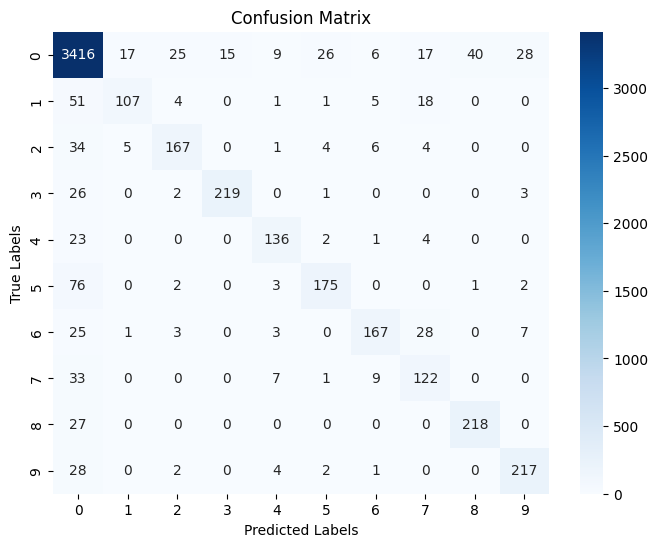

In [ ]:
# confusion matrix
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_test, y_pred_classes)

print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_of_classes), yticklabels=range(num_of_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Analiza skuteczności modeli, porównanie

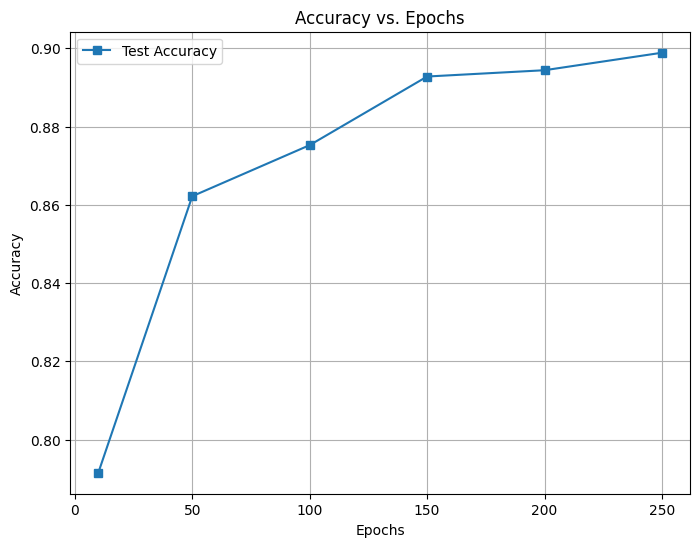

In [ ]:
epochs = [10, 50, 100, 150, 200, 250]
test_accuracies = [accuracy_var2_10, accuracy_var2_50, accuracy_var2_100, accuracy_var2_150, accuracy_var2_200, accuracy_var2_250]

plt.figure(figsize=(8, 6))
plt.plot(epochs, test_accuracies, marker='s', label='Test Accuracy')
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


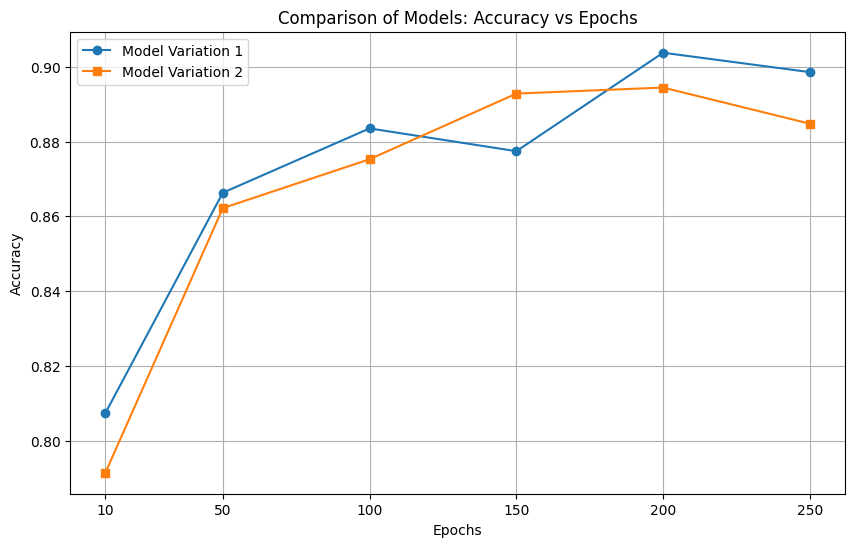

In [ ]:
import matplotlib.pyplot as plt

# Liczba epok
epochs = [10, 50, 100, 150, 200, 250]

# Dokładności dla Model Variation 1
accuracy_var1 = [
    accuracy_var1_10,
    accuracy_var1_50,
    accuracy_var1_100,
    accuracy_var1_150,
    accuracy_var1_200,
    accuracy_var1_250
]

# Dokładności dla Model Variation 2
accuracy_var2 = [
    accuracy_var2_10,
    accuracy_var2_50,
    accuracy_var2_100,
    accuracy_var2_150,
    accuracy_var2_200,
    accuracy_var2_250
]

# Tworzenie wykresu
plt.figure(figsize=(10, 6))

# Linia dla Model Variation 1
plt.plot(epochs, accuracy_var1, marker='o', label='Model Variation 1')

# Linia dla Model Variation 2
plt.plot(epochs, accuracy_var2, marker='s', label='Model Variation 2')

# Ustawienia wykresu
plt.title("Comparison of Models: Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.xticks(epochs)  # Znaczniki na osi X odpowiadające liczbie epok
plt.legend()
plt.grid()
plt.show()
